---

In [77]:
# imports
import os, sys, time

# third party imports
import numpy as np
import torch

In [78]:
os.environ['NEURITE_BACKEND'] = 'pytorch'
os.environ['VXM_BACKEND'] = 'pytorch'

In [79]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cpu



In [80]:
# local imports
import voxelmorph as vxm
import neurite as ne

In [81]:
#Defnining parameters
epochs = 1500 #number of training epochs (default: 1500)
steps_per_epoch = 100 
initial_epoch = 0
batch_size = 8 
lr = 1e-4 #learning rate (default: 1e-4)
# cudnn_nondet = True #disable cudnn determinism - might slow down training
int_steps = 7 #number of integration steps (default: 7)
int_downsize = 2 #flow downsample factor for integration (default: 2)
bidir = False #enable bidirectional cost function
multichannel = False #specify that data has multiple channels
weight = 0.01 #weight of deformation loss (default: 0.01)

In [82]:
# Conform test data.
def conform(x, in_shape = (256,) * 2):
    '''Resize and normalize image.'''
    x = np.float32(x)
    # x = ne.utils.minmax_norm(x)
    # x = ne.utils.zoom(x, zoom_factor=[o / i for o, i in zip(in_shape, x.shape)])
    return np.expand_dims(x, axis=(0, -1))

In [83]:
def vxm_data_generator(x_data, batch_size=32):
    """
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    """

    # preliminary sizing
    vol_shape = x_data.shape[1:] # extract data shape
    ndims = len(vol_shape)

    # prepare a zero array the size of the deformation
    # we'll explain this below
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])

    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx1 = np.random.randint(0, x_data.shape[0], size=batch_size)
        moving_images = x_data[idx1, ..., np.newaxis]
        idx2 = np.random.randint(0, x_data.shape[0], size=batch_size)
        fixed_images = x_data[idx2, ..., np.newaxis]
        inputs = [moving_images, fixed_images]

        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare
        # the resulting moved image with the fixed image.
        # we also wish to penalize the deformation field.
        outputs = [fixed_images, zero_phi]

        yield (inputs, outputs)

In [84]:
import matplotlib.pyplot as plt

def plot_history(hist, loss_name='loss'):
    # Simple function to plot training history.
    plt.figure()
    plt.plot(hist.epoch, hist.history[loss_name], '.-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

In [85]:
# # download MRI tutorial data
# !wget https://surfer.nmr.mgh.harvard.edu/pub/data/voxelmorph/tutorial_data.tar.gz -O data.tar.gz
# !tar -xzvf data.tar.gz

In [86]:
npz = np.load('tutorial_data.npz')
x_train = npz['train']
# conformed_x_train = [conform(img) for img in x_train]
# conformed_x_train = np.array(conformed_x_train)
x_val = npz['validate']
# conformed_x_val = [conform(img) for img in x_val]
# conformed_x_val = np.array(conformed_x_val)

# the 208 volumes are of size 160x192
vol_shape = conformed_x_train.shape[1:]
print('train shape:', x_train.shape)

train shape: (208, 192, 160)


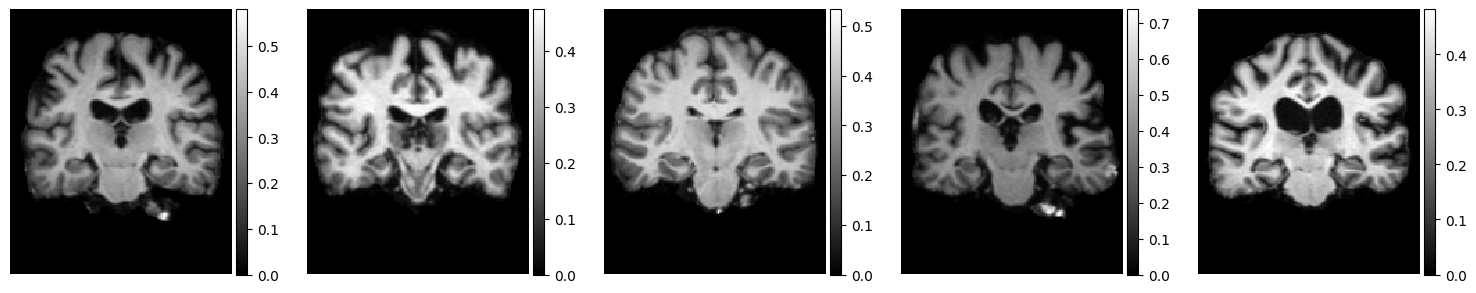

In [87]:
# extract some brains
nb_vis = 5
idx = np.random.randint(0, x_train.shape[0], [5,])
example_digits = [f for f in x_train[idx, ...]]

# visualize
ne.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

In [88]:
#Changing the generator to work with this data set

#Generating inshape using generator
# add_feat_axis = not multichannel

# generator = vxm.generators.scan_to_scan( x_train, batch_size=batch_size, bidir=bidir, add_feat_axis=add_feat_axis)


### Model

As with MNIST, let's create a standard VoxelMorph model trained with MSE and spatial smoothing losses.

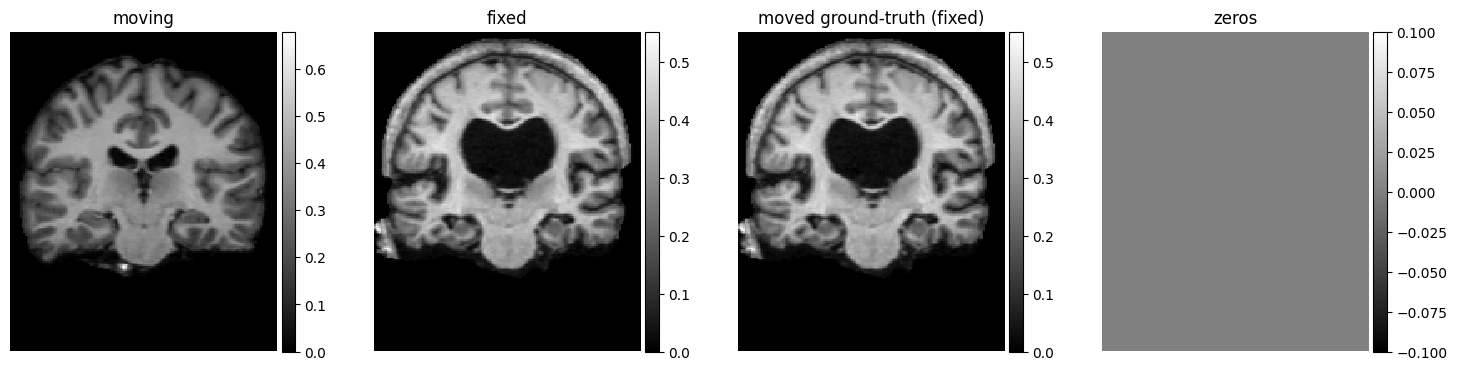

In [89]:
# let's test it
train_generator = vxm_data_generator(x_train, batch_size=batch_size)
inshape = next(train_generator)[0][0].shape[1:-1]
inputs, y_true = next(train_generator)
# in_sample, out_sample = next(train_generator)

# visualize
images = [img[0, :, :, 0] for img in inputs + y_true]
titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

In [90]:
# inputs = np.array(inputs)
# y_true = np.array(y_true)

In [92]:
# unet
# vxm_model = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0)

enc_nf = [16, 32, 32, 32]
dec_nf = [32, 32, 32, 32, 32, 16, 16]

model = vxm.networks.VxmDense(
        inshape=inshape,
        nb_unet_features=[enc_nf, dec_nf],
        bidir=bidir,
        int_steps=int_steps,
        int_downsize=int_downsize
    )

# losses and loss weights
losses = ['mse', vxm.losses.Grad('l2').loss]
loss_weights = [1, 0.01]

In [93]:
model.to(device)
model.train()

VxmDense(
  (unet_model): Unet(
    (encoder): ModuleList(
      (0): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (1): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (2-3): 2 x ModuleList(
        (0): ConvBlock(
          (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
    )
    (decoder): ModuleList(
      (0): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (1-3): 3 x ModuleList(
        (0): ConvBlock(
          (main): Conv2d(64, 32, kerne

In [94]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
image_loss_func = vxm.losses.MSE().loss


if bidir:
    losses = [image_loss_func, image_loss_func]
    weights = [0.5, 0.5]
else:
    losses = [image_loss_func]
    weights = [1]
# prepare deformation loss
losses += [vxm.losses.Grad('l2', loss_mult=int_downsize).loss]
weights += [weight]    

In [95]:
# training loops
for epoch in range(initial_epoch, epochs):

    # # save model checkpoint
    # if epoch % 20 == 0:
    #     model.save(os.path.join(model_dir, '%04d.pt' % epoch))

    epoch_loss = []
    epoch_total_loss = []
    epoch_step_time = []

    for step in range(steps_per_epoch):

        step_start_time = time.time()
        # inputs, y_true = next(generator)

        # generate inputs (and true outputs) and convert them to tensors
        inputs = [torch.from_numpy(d).to(device).float().permute(0, 4, 1, 2, 3) for d in inputs]
        y_true = [torch.from_numpy(d).to(device).float().permute(0, 4, 1, 2, 3) for d in y_true]

        # run inputs through the model to produce a warped image and flow field
        y_pred = model(*inputs)

        # calculate total loss
        loss = 0
        loss_list = []
        for n, loss_function in enumerate(losses):
            curr_loss = loss_function(y_true[n], y_pred[n]) * weights[n]
            loss_list.append(curr_loss.item())
            loss += curr_loss

        epoch_loss.append(loss_list)
        epoch_total_loss.append(loss.item())

        # backpropagate and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # get compute time
        epoch_step_time.append(time.time() - step_start_time)

    # print epoch info
    epoch_info = 'Epoch %d/%d' % (epoch + 1, args.epochs)
    time_info = '%.4f sec/step' % np.mean(epoch_step_time)
    losses_info = ', '.join(['%.4e' % f for f in np.mean(epoch_loss, axis=0)])
    loss_info = 'loss: %.4e  (%s)' % (np.mean(epoch_total_loss), losses_info)
    print(' - '.join((epoch_info, time_info, loss_info)), flush=True)

# final model save
# model.save(os.path.join(model_dir, '%04d.pt' % args.epochs))

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 5

Looks good, time to **train the model**

##### *Issues with the generator the file generators.py at /lib/python3.9/site-packages/voxelmorph/*

The data has to be passed through a generator for the furthur processing now there is a probable issue with that ^^^ above

In [ ]:
hist = vxm_model.fit_generator(train_generator, epochs=5, steps_per_epoch=5, verbose=2);

In [ ]:
# as before, let's visualize what happened
plot_history(hist)

Now let's see some results using validation data...

In [ ]:
# create the validation data generator
val_generator = vxm_data_generator(x_val, batch_size = 1)
val_input, _ = next(val_generator)

In [ ]:
# prediction
val_pred = vxm_model.predict(val_input)

In [ ]:
# visualize registration
images = [img[0, :, :, 0] for img in val_input + val_pred]
titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

In [ ]:
# visualize flow
flow = val_pred[1].squeeze()[::3,::3]
ne.plot.flow([flow], width=5);

# Evaluation

Evaluating registration results is tricky. The first tendancy is to look at the images (as above), and conclude that if they match, The registration has succeeded.

However, this can be achieved by an optimization that only penalizes the image matching term. For example, next we compare our model with one that was trained on maximizing MSE only (without smoothness loss).

In [ ]:
# # prediction from model with MSE + smoothness loss
# vxm_model.load_weights('brain_2d_smooth.h5')
# our_val_pred = vxm_model.predict(val_input)

# # prediction from model with just MSE loss
# vxm_model.load_weights('brain_2d_no_smooth.h5')
# mse_val_pred = vxm_model.predict(val_input)

In [ ]:
# # visualize MSE + smoothness model output
# images = [img[0, ..., 0] for img in [val_input[1], *our_val_pred]]
# titles = ['fixed', 'MSE + smoothness', 'flow']
# ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

# # visualize MSE model output
# images = [img[0, ..., 0] for img in [val_input[1], *mse_val_pred]]
# titles = ['fixed', 'MSE only', 'flow']
# ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

In [ ]:
# ne.plot.flow([img[1].squeeze()[::3, ::3] for img in [our_val_pred, mse_val_pred]], width=10);